<a href="https://colab.research.google.com/github/GummyBear-w/aop113b/blob/main/HW04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 問題定義
- **目標**：根據旅客的基本資料（如年齡、性別、船艙等），預測其在 Titanic 船難中的生存狀態。
- **任務類型**：二元分類（生存 / 死亡）。
- **核心模型**：KNN，並與 Random Forest 比較。
- **評估指標**：Accuracy、Precision、Recall、F1、混淆矩陣。

## 資料讀取與初步檢視

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('/content/drive/MyDrive/Titanic-Dataset.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## 資料清理與EDA

In [13]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


### 確認資料缺失情況

In [12]:
print(df.isnull().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


### 填補缺失值

In [15]:
df['Age'] = df['Age'].fillna(df['Age'].median())
df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])

# Cabin 欄位有太多缺失值
df.drop('Cabin', axis=1, inplace=True)

# 顯示缺值確認
print(df.isnull().sum())

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64


### 生存與死亡人數長條圖

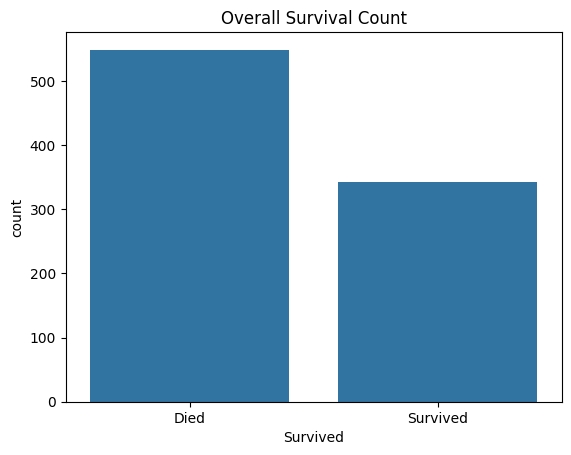

In [17]:
sns.countplot(data=df, x='Survived')
plt.title('Overall Survival Count')
plt.xticks([0, 1], ['Died', 'Survived'])
plt.show()

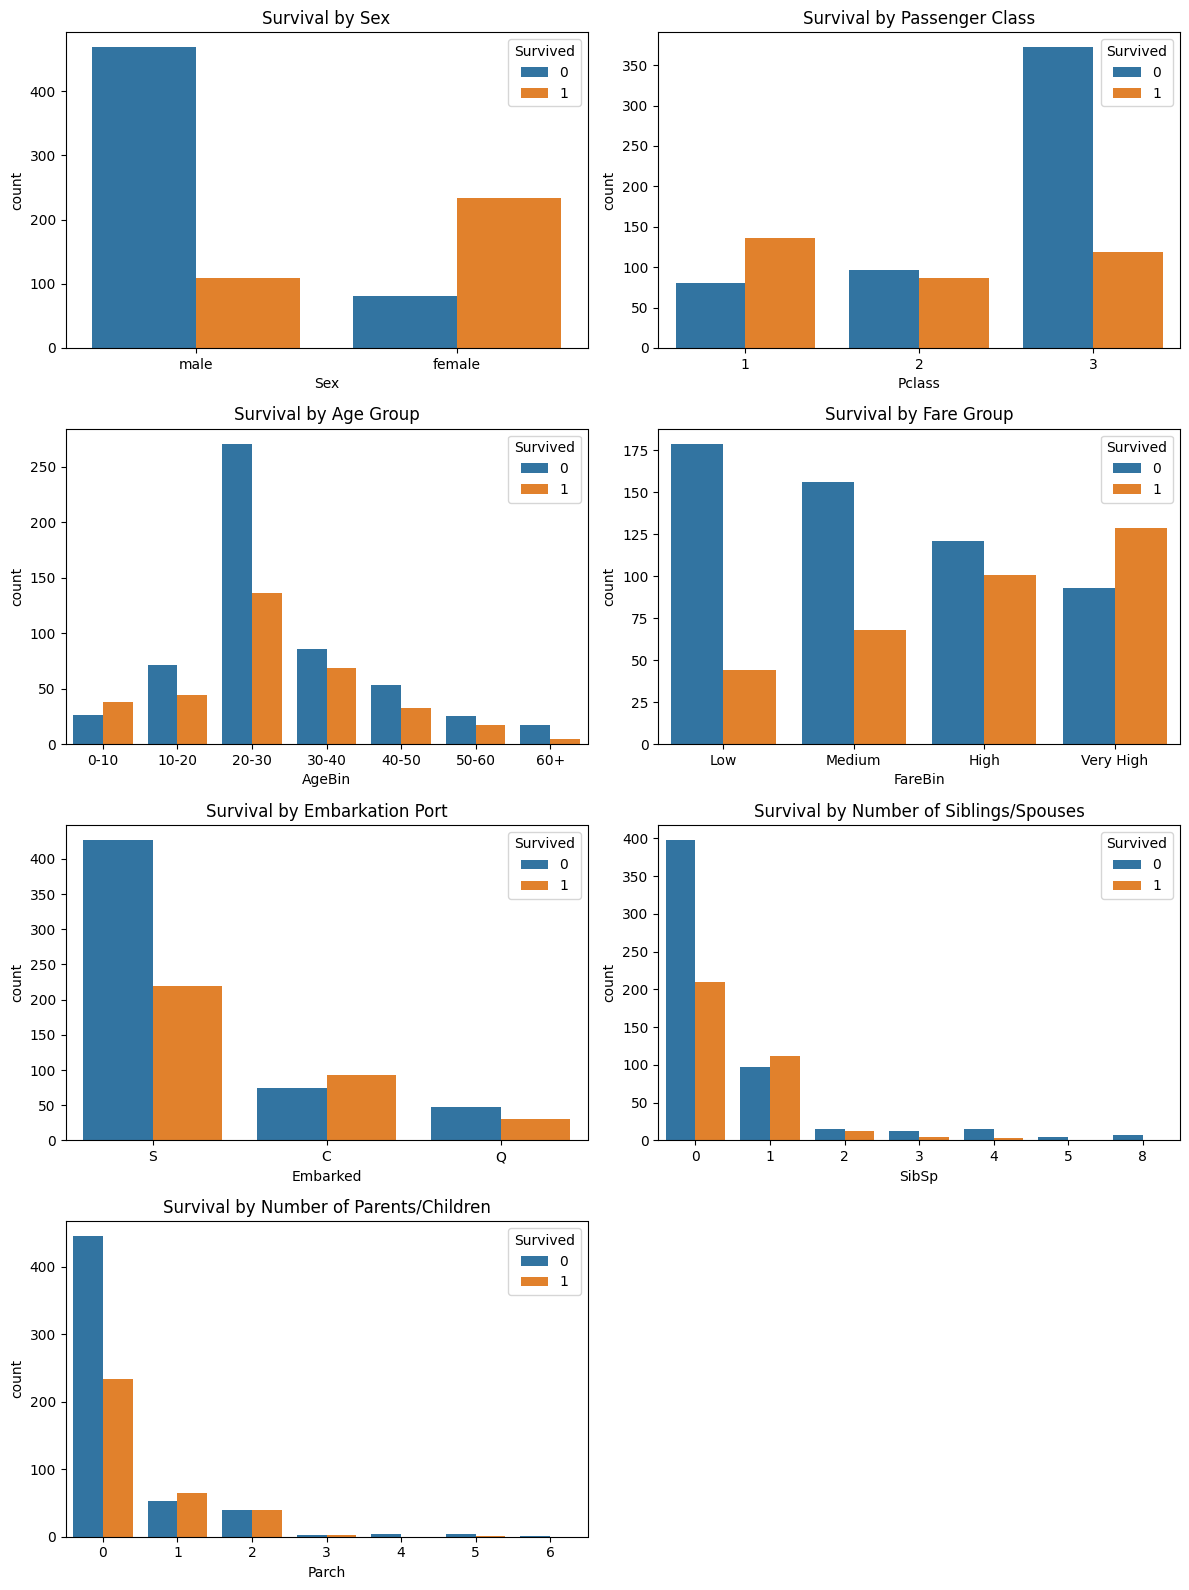

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# 分箱：Age（每10歲一區）
df['AgeBin'] = pd.cut(df['Age'], bins=[0, 10, 20, 30, 40, 50, 60, 80], labels=['0-10','10-20','20-30','30-40','40-50','50-60','60+'])

# 分箱：Fare（四等分）
df['FareBin'] = pd.qcut(df['Fare'], q=4, labels=['Low', 'Medium', 'High', 'Very High'])

plt.figure(figsize=(12, 16))

# Sex
plt.subplot(4, 2, 1)
sns.countplot(data=df, x='Sex', hue='Survived')
plt.title('Survival by Sex')

# Pclass
plt.subplot(4, 2, 2)
sns.countplot(data=df, x='Pclass', hue='Survived')
plt.title('Survival by Passenger Class')

# Age (分箱)
plt.subplot(4, 2, 3)
sns.countplot(data=df, x='AgeBin', hue='Survived')
plt.title('Survival by Age Group')

# Fare (分箱)
plt.subplot(4, 2, 4)
sns.countplot(data=df, x='FareBin', hue='Survived')
plt.title('Survival by Fare Group')

# Embarked
plt.subplot(4, 2, 5)
sns.countplot(data=df, x='Embarked', hue='Survived')
plt.title('Survival by Embarkation Port')

# SibSp
plt.subplot(4, 2, 6)
sns.countplot(data=df, x='SibSp', hue='Survived')
plt.title('Survival by Number of Siblings/Spouses')

# Parch
plt.subplot(4, 2, 7)
sns.countplot(data=df, x='Parch', hue='Survived')
plt.title('Survival by Number of Parents/Children')

plt.tight_layout()
plt.show()


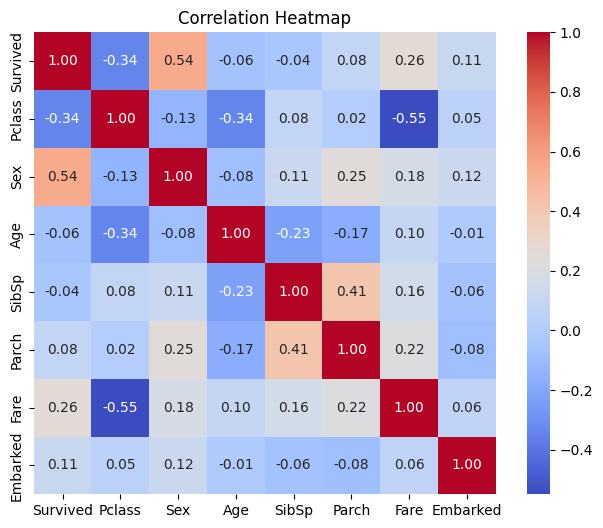

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt


df_corr = df.copy()
df_corr['Sex'] = df_corr['Sex'].map({'male': 0, 'female': 1})
df_corr['Embarked'] = df_corr['Embarked'].map({'S': 0, 'C': 1, 'Q': 2})

# 選擇相關的數值欄位
corr_matrix = df_corr[['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch',
                       'Fare', 'Embarked']].corr()

# 畫圖
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title("Correlation Heatmap")
plt.show()

從圖中可以看出性別與生存之間有明顯的正相關，女性乘客的生還機率相對較高；而艙等與票價則分別呈現負相關與正相關，反映出社經地位較高的乘客在船難中有較高的生還率。

## Feature Engineering

In [27]:
features = ['Pclass', 'Sex', 'Age', 'Fare', 'Embarked', 'SibSp', 'Parch']

df['Sex'] = df['Sex'].map({'male': 0, 'female': 1})
df['Embarked'] = df['Embarked'].map({'S': 0, 'C': 1, 'Q': 2})

# 建立 X/y
X = df[features]
y = df['Survived']

## 分割資料集

In [28]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [29]:
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

X_train shape: (712, 7)
X_test shape: (179, 7)


## 特徵縮放

In [30]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## 模型訓練與預測

In [31]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

# KNN 模型
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)

# Random Forest 模型
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

## 模型評估與混淆矩陣

KNN 評估結果
              precision    recall  f1-score   support

           0       0.82      0.87      0.84       105
           1       0.79      0.73      0.76        74

    accuracy                           0.81       179
   macro avg       0.81      0.80      0.80       179
weighted avg       0.81      0.81      0.81       179



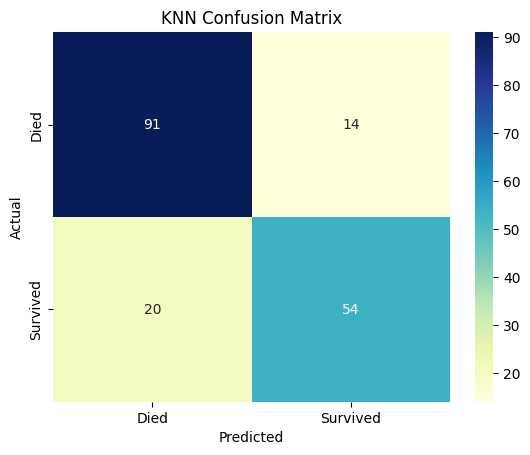

Random Forest 評估結果
              precision    recall  f1-score   support

           0       0.83      0.86      0.85       105
           1       0.79      0.76      0.77        74

    accuracy                           0.82       179
   macro avg       0.81      0.81      0.81       179
weighted avg       0.81      0.82      0.82       179



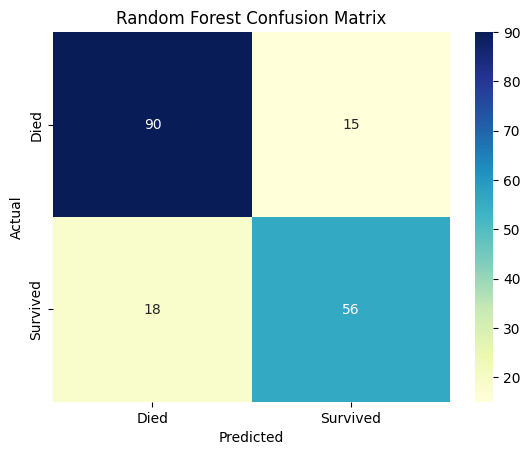

In [32]:
from sklearn.metrics import classification_report, confusion_matrix

def plot_conf_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu',
                xticklabels=['Died', 'Survived'],
                yticklabels=['Died', 'Survived'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()

print('KNN 評估結果')
print(classification_report(y_test, y_pred_knn, zero_division=0))
plot_conf_matrix(y_test, y_pred_knn, 'KNN Confusion Matrix')

print('Random Forest 評估結果')
print(classification_report(y_test, y_pred_rf, zero_division=0))
plot_conf_matrix(y_test, y_pred_rf, 'Random Forest Confusion Matrix')

兩個模型在預測 Titanic 乘客生還情況上皆有不錯表現，整體準確率（accuracy）分別為 KNN 的 81% 以及 Random Forest 的 82%，差異不大。

KNN 模型在預測「未生還者」（label = 0）上表現稍佳，recall 達到 0.87，表示能準確找出大部分未生還的乘客。不過對「生還者」的 recall 僅 0.73，代表仍有部分生還者被誤判為死亡。相較之下，Random Forest 的表現則更為平衡，其對生還者的 precision 與 recall 分別為 0.79 與 0.76，比 KNN 略好，且 F1-score 達到 0.77，是兩者中對正類（生還）表現最佳的模型。

綜合來看，雖然兩者差距不大，但 Random Forest 在穩定性與整體平衡性上略勝一籌，更適合作為 Titanic 生存預測的模型。

## 針對隨機森林進行超參數調整

Fitting 5 folds for each of 96 candidates, totalling 480 fits
最佳參數組合： {'class_weight': None, 'max_depth': 6, 'max_features': 'sqrt', 'min_samples_split': 10, 'n_estimators': 200}
交叉驗證最佳準確率： 0.8286
測試集評估結果：

              precision    recall  f1-score   support

           0       0.81      0.91      0.86       105
           1       0.85      0.69      0.76        74

    accuracy                           0.82       179
   macro avg       0.83      0.80      0.81       179
weighted avg       0.82      0.82      0.82       179



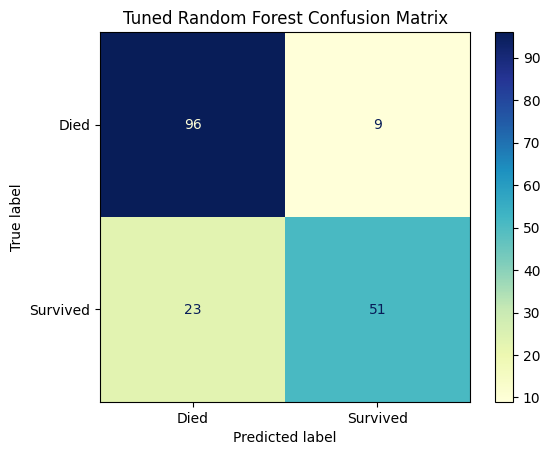

In [33]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# 定義參數網格（grid）
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [4, 6, 8, None],
    'max_features': ['sqrt', 'log2'],
    'min_samples_split': [2, 5, 10],
    'class_weight': [None, 'balanced']
}

# 建立模型
rf = RandomForestClassifier(random_state=42)

# 建立 GridSearch
grid_search = GridSearchCV(estimator=rf,
                           param_grid=param_grid,
                           cv=5,           # 5-fold cross-validation
                           scoring='accuracy',
                           n_jobs=-1,
                           verbose=1)

# 執行搜尋
grid_search.fit(X_train, y_train)

# 輸出最佳參數組合與準確率
print("最佳參數組合：", grid_search.best_params_)
print("交叉驗證最佳準確率：", round(grid_search.best_score_, 4))

# 用最佳模型預測測試集
best_rf = grid_search.best_estimator_
y_pred_rf_tuned = best_rf.predict(X_test)

# 評估模型
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
print("測試集評估結果：\n")
print(classification_report(y_test, y_pred_rf_tuned))

# 混淆矩陣
import matplotlib.pyplot as plt
cm = confusion_matrix(y_test, y_pred_rf_tuned)
disp = ConfusionMatrixDisplay(cm, display_labels=['Died', 'Survived'])
disp.plot(cmap='YlGnBu')
plt.title("Tuned Random Forest Confusion Matrix")
plt.show()

調整後的 Random Forest 雖在整體準確率維持 82%，但對於生還者的 recall 從原本的 76% 降至 69%，代表模型在預測生還者時更保守，提高了死亡者預測的穩定性（TN 從 90 → 96），但也犧牲了部分真正生還者的預測能力（TP 從 56 → 51）。

## 結論

本研究以 Titanic 乘客資料進行生還預測，採用 KNN 與 Random Forest 兩種模型進行比較，並透過交叉驗證與網格搜尋調整參數。整體而言，兩個模型準確率皆達 81–82%，但在預測「生還者」這個正類別上的表現有所不同。

初步訓練結果顯示，Random Forest 模型對生還者的預測 recall（找出真正生還者的能力）為 76%，而 KNN 為 73%。在進行超參數調整後，Random Forest 的 recall 下降為 69%，但 precision（預測為生還者時命中的準確率）提升至 85%。這代表模型變得較保守，比較不容易誤判死亡者為生還者，但也會漏掉一些真正會生還的人。

若本模型應用於災難情境中，目標是「不要錯過任何可能生還的人」，那麼 recall 應為優先考量，此時可以選擇未調參的模型，或考慮進一步優化 recall。反之，若目的是「只要預測某人會生還，這個判斷就必須準確可靠」，那麼較高的 precision 是更合適的選擇，此時可採用調參後模型。